<a href="https://colab.research.google.com/github/markusdiekmann95/Morph-U-Net/blob/main/Morph_U_Net_Inria_Vienna_Strong_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up and Imports

In [ ]:
## Standard libraries
import os
import math
import numpy as np 
import time
import cv2

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)

Using torch 1.10.0+cu111


In [ ]:
torch.manual_seed(42) # Setting the seed
import random
random.seed(42)
np.random.seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan 25 18:05:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




# Data Set



In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
from PIL import Image
import random
from scipy import ndimage
from glob import glob
import torch.utils.data as data

class segDataset(data.Dataset):
  def __init__(self, img_path, gt_path, training, transform=None):
        super(segDataset, self).__init__()
        self.training = training
        self.transform = transform
        self.img = img_path
        self.gt = gt_path
        self.images = os.listdir(self.img)

    
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.img, self.images[idx])
    mask_path = os.path.join(self.gt, self.images[idx].replace(".jpg", "_mask.gif"))
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
    mask[mask == 255.0] = 1.0
    image = np.moveaxis(image, -1, 0)/255

    return torch.Tensor(image), torch.Tensor(mask)

  def __len__(self):
    return len(self.images)
    




In [ ]:
#Initialize the dataset for Inria - https://project.inria.fr/aerialimagelabeling/contest/
data = segDataset("/content/drive/MyDrive/Colab Notebooks/Inria/Prep_Data/img", "/content/drive/MyDrive/Colab Notebooks/Inria/Prep_Data/gt", training=True)

In [ ]:
test_num = int(0.1 * len(data))
print(len(data))  #Number of images in dataset
print(test_num) #Test Set Size of 10%

600
60


In [ ]:
#Split Up Dataset into Train Set and Test Set
train_dataset, test_dataset = torch.utils.data.random_split(data, [len(data)-test_num, test_num], generator=torch.Generator())

In [ ]:
N_DATA, N_TEST = len(train_dataset), len(test_dataset)
print(N_DATA)

540


In [ ]:
# Dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

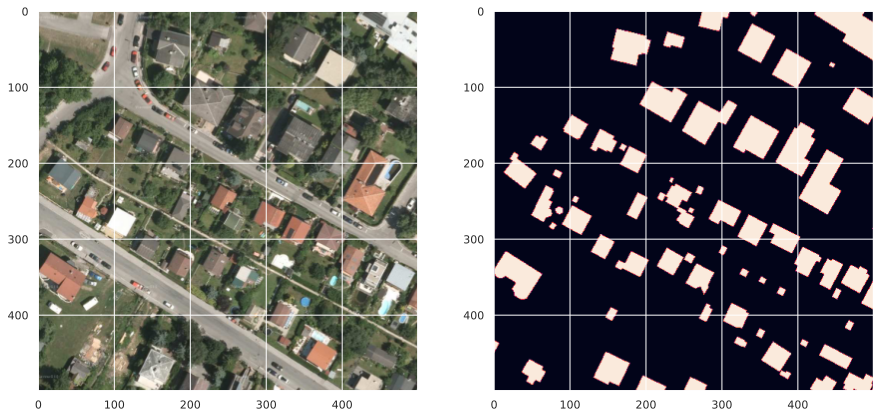

In [ ]:
# Example Plots
d = data[20]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(d[0].permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

#Seed Model for Base Model and Model with Sparse Regularization

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


In [ ]:
def crop_tensor(tensor, target_tensor):
    '''Skip Connections'''
  target_size = target_tensor.size()[2] #2 or 3 for image size
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]

In [ ]:
features=[64,128,256,512,1024]
print(features[::-1])

[1024, 512, 256, 128, 64]


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.red = ([64,64,128,128,256,256,512,512,512,512,256,256,128,128,64,64,1024,1024])  #Feature Maps of the Network
        self.conv0_0 = nn.Conv2d(3,self.red[0],kernel_size=3, padding="same")
        self.conv0_1 = nn.Conv2d(self.red[0],self.red[1],kernel_size=3, padding="same")
        self.conv1_0 = nn.Conv2d(self.red[1],self.red[2],kernel_size=3, padding="same")
        self.conv1_1 = nn.Conv2d(self.red[2],self.red[3],kernel_size=3, padding="same")
        self.conv2_0 = nn.Conv2d(self.red[3],self.red[4],kernel_size=3, padding="same")
        self.conv2_1 = nn.Conv2d(self.red[4],self.red[5],kernel_size=3, padding="same")
        self.conv3_0 = nn.Conv2d(self.red[5],self.red[6],kernel_size=3, padding="same")
        self.conv3_1 = nn.Conv2d(self.red[6],self.red[7],kernel_size=3, padding="same")
        self.conv4_0 = nn.Conv2d(self.red[7],self.red[16],kernel_size=3, padding="same")
        self.conv4_1 = nn.Conv2d(self.red[16],self.red[17],kernel_size=3, padding="same")

        self.bn0_0 = nn.BatchNorm2d(self.red[0])
        self.bn0_1 = nn.BatchNorm2d(self.red[1])
        self.bn1_0 = nn.BatchNorm2d(self.red[2])
        self.bn1_1 = nn.BatchNorm2d(self.red[3])
        self.bn2_0 = nn.BatchNorm2d(self.red[4])
        self.bn2_1 = nn.BatchNorm2d(self.red[5])
        self.bn3_0 = nn.BatchNorm2d(self.red[6])
        self.bn3_1 = nn.BatchNorm2d(self.red[7])
        self.bn4_0 = nn.BatchNorm2d(self.red[16])
        self.bn4_1 = nn.BatchNorm2d(self.red[17])
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=self.red[17], out_channels=self.red[7], kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=self.red[9], out_channels=self.red[5], kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=self.red[11], out_channels=self.red[3], kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=self.red[13], out_channels=self.red[1], kernel_size=2, stride=2)

        self.conv5_0 = nn.Conv2d(self.red[7]*2,self.red[8],kernel_size=3, padding="same")
        self.conv5_1 = nn.Conv2d(self.red[8],self.red[9],kernel_size=3, padding="same")
        self.conv6_0 = nn.Conv2d(self.red[5]*2,self.red[10],kernel_size=3, padding="same")
        self.conv6_1 = nn.Conv2d(self.red[10],self.red[11],kernel_size=3, padding="same")
        self.conv7_0 = nn.Conv2d(self.red[3]*2,self.red[12],kernel_size=3, padding="same")
        self.conv7_1 = nn.Conv2d(self.red[12],self.red[13],kernel_size=3, padding="same")
        self.conv8_0 = nn.Conv2d(self.red[1]*2,self.red[14],kernel_size=3, padding="same")
        self.conv8_1 = nn.Conv2d(self.red[14],self.red[15],kernel_size=3, padding="same")

        self.bn5_0 = nn.BatchNorm2d(self.red[8])
        self.bn5_1 = nn.BatchNorm2d(self.red[9])
        self.bn6_0 = nn.BatchNorm2d(self.red[10])
        self.bn6_1 = nn.BatchNorm2d(self.red[11])
        self.bn7_0 = nn.BatchNorm2d(self.red[12])
        self.bn7_1 = nn.BatchNorm2d(self.red[13])
        self.bn8_0 = nn.BatchNorm2d(self.red[14])
        self.bn8_1 = nn.BatchNorm2d(self.red[15])

        self.out = nn.Conv2d(in_channels=self.red[15], out_channels=1, kernel_size=1)#outchannels = num classes

    def forward(self, x):
        #Down
        c0 = self.conv0_0(x)
        c0 = self.relu(c0)
        c0 = self.bn0_0(c0)
        c0 = self.conv0_1(c0)
        c0 = self.relu(c0)
        c0 = self.bn0_1(c0)
        c1 = self.max_pool_2x2(c0)
        c1 = self.conv1_0(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_0(c1)
        c1 = self.conv1_1(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_1(c1)

        c2 = self.max_pool_2x2(c1)
        c2 = self.conv2_0(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_0(c2)
        c2 = self.conv2_1(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_1(c2)
        c3 = self.max_pool_2x2(c2)
        c3 = self.conv3_0(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_0(c3)
        c3 = self.conv3_1(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_1(c3)

        c4 = self.max_pool_2x2(c3)
        c4 = self.conv4_0(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_0(c4)
        c4 = self.conv4_1(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_1(c4)
        #Up
        up = self.up_trans_1(c4)
        y = crop_tensor(c3,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv5_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn5_0(up)
        up = self.conv5_1(up)
        up = self.relu(up)
        up = self.bn5_1(up)
        del c4, y
        up = self.up_trans_2(up)
        y = crop_tensor(c2,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv6_0(torch.cat([up,y], 1))
        self.relu(up)
        up = self.bn6_0(up)
        up = self.conv6_1(up)
        self.relu(up)
        up = self.bn6_1(up)
        
        del c3, y
        up = self.up_trans_3(up)
        y = crop_tensor(c1,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv7_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn7_0(up)
        up = self.conv7_1(up)
        up = self.relu(up)
        up = self.bn7_1(up)
        del c2, y
        up = self.up_trans_4(up)
        y = crop_tensor(c0,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv8_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn8_0(up)
        up = self.conv8_1(up)
        up = self.relu(up)
        up = self.bn8_1(up)
        del c0, c1, y

        x = self.out(up)
        return x

# Model Training Functions and Classes

## Regularization for MorphNet

In [ ]:
#https://leimao.github.io/blog/Group-Lasso/
def group_lasso_reg(layer):
    '''Takes a layer as input and performs group lasso on it'''
  num_w = layer.numel()
  eucl_norm = torch.sqrt(l2_reg(layer))
  return torch.sqrt(torch.tensor(num_w)) * eucl_norm

In [ ]:
def model_size_C(layer):
    '''Takes a layer as input and compute it's model size C '''
  res = torch.tensor(0.)
  x = torch.Tensor(2)
  x[0] = torch.tensor([layer.shape[2]])
  x[1] = torch.tensor([layer.shape[3]])
  res = torch.prod(x)
  return res.cuda()

In [ ]:
def flops_C(layer):
    '''Takes a layer as input and compute it's FLOPs C '''
  if not len(layer.size())==4:
    "Wrong Layer! Len of Size must be 4!"
  x = torch.Tensor(4)
  x[0] = torch.tensor([layer.shape[0]])
  x[1] = torch.tensor([layer.shape[1]])
  x[2] = torch.tensor([layer.shape[2]])
  x[3] = torch.tensor([layer.shape[3]])
  flops = 2 * torch.prod(x)
  return flops.cuda()

In [ ]:
def l1_reg(layer):
    '''Takes a layer as input and performs L1 Regularization on it'''
  l1 = 0
  for param in layer:
    l1 += torch.sum(torch.abs(param))
  return l1

In [ ]:
def l2_reg(layer):
    '''Takes a layer as input and performs L2 Regularization on it'''
  l2 = 0
  for param in layer:
    #for param in filter:
      l2 += torch.sum(torch.pow(param,2))
  return l2

In [ ]:
def zero_out_indicator(layer, threshold=0.0001):
  '''
  layer: Convolution Layer Weights
  threshold: If neuron is below this threshold, it is not alive
  returns: Number of neurons which are alive
  '''
  res = torch.Tensor(layer.size())
  al = 0
  res = torch.where(layer.abs() > torch.tensor(threshold).cuda(), torch.tensor(1.).cuda(), torch.tensor(0.).cuda())
  al = torch.sum(res)
  return al

In [ ]:
def group_lasso_regularizer(model, threshold=0.0001):
    ''' Takes the model and threshold as input and 
  computes the costs based on Group Lasso Regularization'''
  last_module = None
  costs = 0.
  for name, param in model.named_parameters():
    if ("conv" in name) and ("weight" in name):
      if last_module is None:
        costs += param.size()[2]*param.size()[3] * zero_out_indicator(param.cuda()) * 0 
          #Output
        costs += param.size()[2]*param.size()[3] * group_lasso_reg(param) * 3 
        last_module = param
      else:
          #Input
        costs += param.size()[2]*param.size()[3] * group_lasso_reg(last_module) * zero_out_indicator(param.cuda(),threshold) 
          #Output
        costs += param.size()[2]*param.size()[3] * group_lasso_reg(param) * zero_out_indicator(last_module.cuda(),threshold) 

        last_module = param
  
  return costs

## Loss ...

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    ''' Takes a dataloader and the model as input and returns
  accuracy and dice score'''
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
    return num_correct/num_pixels, dice_score/len(loader)

In [ ]:
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
#Credits: https://github.com/tatigabru/inria
class DiceLoss(_Loss):
    """
    Implementation of dice loss 
    for binary image segmentation task, calculated from logits
        Args: 
            log_loss: if True, loss computed as `-log(dice)`; otherwise `1 - dice`
            log_sigmoid: if True, uses F.logsigmoid(y_pred).exp(), otherwise uses torch.sigmoid(y_pred)  
            smooth: smooth the loss values, should be float between 0 and 1
            reduction: str = 'mean', 'sum' or 'none'. Default = 'mean'
        Output: loss as a float or Tensor (for reduction 'none')    
    """
    def __init__(self, log_sigmoid: bool=True, log_loss: bool=False, smooth: float=0.0, reduction: str = 'mean'):

        super(DiceLoss, self).__init__()
  
        self.log_sigmoid = log_sigmoid
        self.log_loss = log_loss
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, y_pred, y_true):
        """
        Args:
            y_pred: binary masks of shape Nx1xHxW
            y_true: binary masks of shape Nx1xHxW        
        """
        if y_true.size() != y_pred.size(): raise ValueError("Model outputs and targetd mush have the same size: Nx1xHxW")         
        eps = 1e-7

        if self.log_sigmoid:            
            # Log-Exp more numerically stable and does not cause vanishing gradient on
            # extreme values of 0 and 1
            outputs = F.logsigmoid(y_pred).exp()
        else:
            #outputs = y_pred    
            outputs = torch.sigmoid(y_pred)        
        targets = (y_true == 1).type_as(outputs) # ensure the same type

        intersection = torch.sum(outputs * targets)
        cardinality = torch.sum(outputs + targets)
        loss = (intersection + self.smooth) / (cardinality.clamp_min(eps) + self.smooth)
        
        if self.log_loss:
            loss = -torch.log(scores.clamp_min(eps))
        else:
            loss = 1 - loss
        
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()  

        return loss

## Training

In [ ]:
def train_model_with_reg(model, optimizer, data_loader,loss_module, model_save, num_epochs=10, threshold=0.0001, factor=1e-10 ):
  '''Performs the model training with group lasso regularization'''
    best_score = 0.
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        loss_list = []
        temp_loss_list = []
        acc_list = []
        dic_list = []
        cost_list = []

        for batch_i, (data_inputs,data_labels) in enumerate(data_loader):
            

            data_inputs = data_inputs.to(device) 
            data_labels = data_labels.float().unsqueeze(1).to(device)
            data_inputs.size()
            data_labels.size()

            pred_mask = model(data_inputs)

            costs =  group_lasso_regularizer(model, threshold)#gamma_regularizer(model, model_size_C)
            

            ## TODO: Step 3 - Calculate the loss using the module loss_module
            _temp_loss = loss_module(pred_mask, data_labels) 
            _loss = _temp_loss + factor * costs



            ## TODO: Step 4 - Perform backpropagation
            optimizer.zero_grad()
            _loss.backward()
            #print("success")
            ## TODO: Step 5 - Update parameters
            optimizer.step( )
            loss_list.append(_loss.cpu().detach().numpy())
            temp_loss_list.append(_temp_loss.cpu().detach().numpy())


        accuracy, dice = check_accuracy(train_dataloader, model, device)  
        tr_acc = accuracy.cpu().detach().numpy()    
        tr_dic = dice.cpu().detach().numpy()  
        accuracy, dice = check_accuracy(test_dataloader, model, device)  
        val_acc = accuracy.cpu().detach().numpy()    
        val_dic = dice.cpu().detach().numpy()   
        costs = costs.cpu().detach().numpy()


        if  val_dic >= best_score:
          best_score = val_dic 
          torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Inria/Models/" + model_save)
        print(' epoch {} - loss : {:.5f} - costs : {:.1f} - total_loss : {:.2f} - tr_acc : {:.2f} - tr-dic : {:.2f} - val_acc : {:.2f} - val-dic : {:.2f} '.format(epoch, np.mean(temp_loss_list), costs, np.mean(loss_list), tr_acc, tr_dic, val_acc, val_dic)) 
        #print(' epoch {} - loss : {:.5f} - costs : {:.2f} - tr_acc : {:.2f} - tr-dic : {:.2f} - val_acc : {:.2f} - val-dic : {:.2f} '.format(epoch, np.mean(loss_list), costs, tr_acc, tr_dic, val_acc, val_dic)) 

In [ ]:
def train_model(model, optimizer, data_loader,loss_module, model_save, num_epochs=10):
  '''Performs the model training without regularization'''
    best_score = 0.
    model.train() 
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        loss_list = []
        acc_list = []
        dic_list = []
        cost_list = []

        for batch_i, (data_inputs,data_labels) in enumerate(data_loader):
            

            data_inputs = data_inputs.to(device) 
            data_labels = data_labels.float().unsqueeze(1).to(device)
            data_inputs.size()
            data_labels.size()

            pred_mask = model(data_inputs)

            ## TODO: Step 3 - Calculate the loss using the module loss_module
            _loss = loss_module(pred_mask, data_labels) 

            ## TODO: Step 4 - Perform backpropagation
            optimizer.zero_grad()
            _loss.backward()
            #print("success")
            ## TODO: Step 5 - Update parameters
            optimizer.step( )
            loss_list.append(_loss.cpu().detach().numpy())


        accuracy, dice = check_accuracy(train_dataloader, model, device)  
        tr_acc = accuracy.cpu().detach().numpy()    
        tr_dic = dice.cpu().detach().numpy()  
        accuracy, dice = check_accuracy(test_dataloader, model, device)  
        val_acc = accuracy.cpu().detach().numpy()    
        val_dic = dice.cpu().detach().numpy()   

        if  val_dic >= best_score:
          best_score = val_dic 
          torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Inria/Models/" + model_save)
        print(' epoch {} - loss : {:.5f} - tr_acc : {:.2f} - tr-dic : {:.2f} - val_acc : {:.2f} - val-dic : {:.2f} '.format(epoch, np.mean(loss_list), tr_acc, tr_dic, val_acc, val_dic)) 

## Evaluation

In [ ]:
def eval_model(model, data_loader):
  '''Create Predictions on the model'''
  model.eval()

  for batch_i, (x, y) in enumerate(data_loader):
      for j in range(2):
          result = model(x.to(device)[j:j+1])
          mask = torch.sigmoid(result.cpu())
          #mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
          mask = (mask > 0.5).float()
          mask = mask.reshape(500,500)
          #print(mask)
          #print(mask[mask!=0])
          im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
          im = im.astype(int)
          gt_mask = y[j]
          #print(gt_mask)
          plt.figure(figsize=(12,12))
          #print(acc(y,result))
          plt.subplot(1,3,1)
          im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
          im = im.astype(int)
          plt.grid(b=False)
          plt.axis('off')
          plt.imshow(im)

          plt.subplot(1,3,2)
          plt.grid(b=False)
          plt.axis('off')
          plt.imshow(gt_mask)

          plt.subplot(1,3,3)
          plt.grid(b=False)
          plt.axis('off')
          plt.imshow(mask)

          plt.show()

# Train Base Model without Sparse Regularization (For Comparison)

## Initialize Model

In [ ]:
base_model = UNet()
base_model.to(device)

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
from torchsummary import summary
summary(base_model,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 500, 500]           1,792
              ReLU-2         [-1, 64, 500, 500]               0
       BatchNorm2d-3         [-1, 64, 500, 500]             128
            Conv2d-4         [-1, 64, 500, 500]          36,928
              ReLU-5         [-1, 64, 500, 500]               0
       BatchNorm2d-6         [-1, 64, 500, 500]             128
         MaxPool2d-7         [-1, 64, 250, 250]               0
            Conv2d-8        [-1, 128, 250, 250]          73,856
              ReLU-9        [-1, 128, 250, 250]               0
      BatchNorm2d-10        [-1, 128, 250, 250]             256
           Conv2d-11        [-1, 128, 250, 250]         147,584
             ReLU-12        [-1, 128, 250, 250]               0
      BatchNorm2d-13        [-1, 128, 250, 250]             256
        MaxPool2d-14        [-1, 128, 1

## Train Model

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM
train_model(base_model, optimizer, train_dataloader, loss_module, model_save="base_model", num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

N_Parameter: 31,043,521 \
Time: 32:49 \
Tr_Acc: 0.94 \
Tr_Dice: 0.88 \
Val_Acc: 0.94 \
Val-Dic: 0.86 

In [ ]:
print(base_model.bn0_1.weight)
print(base_model.bn3_1.weight)

### Predictions

In [ ]:
eval_model(base_model, test_dataloader)

# Step 1 Training with Sparse Regularization

## Initialize Model

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()
model = UNet()
model.to(device)

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
from torchsummary import summary
summary(model,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 500, 500]           1,792
              ReLU-2         [-1, 64, 500, 500]               0
       BatchNorm2d-3         [-1, 64, 500, 500]             128
            Conv2d-4         [-1, 64, 500, 500]          36,928
              ReLU-5         [-1, 64, 500, 500]               0
       BatchNorm2d-6         [-1, 64, 500, 500]             128
         MaxPool2d-7         [-1, 64, 250, 250]               0
            Conv2d-8        [-1, 128, 250, 250]          73,856
              ReLU-9        [-1, 128, 250, 250]               0
      BatchNorm2d-10        [-1, 128, 250, 250]             256
           Conv2d-11        [-1, 128, 250, 250]         147,584
             ReLU-12        [-1, 128, 250, 250]               0
      BatchNorm2d-13        [-1, 128, 250, 250]             256
        MaxPool2d-14        [-1, 128, 1

## Train Model with Sparse Regularization

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM

In [ ]:
train_model_with_reg(model, optimizer, train_dataloader, loss_module, model_save="gl_reg_model", num_epochs= 15, threshold=0.001, factor=1e-3)

  0%|          | 0/15 [00:00<?, ?it/s]

 epoch 0 - loss : 0.82928 - costs : 1052609472.0 - total_loss : 975868.06 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.34 
 epoch 1 - loss : 0.80985 - costs : 777742784.0 - total_loss : 883215.81 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.36 
 epoch 2 - loss : 0.80940 - costs : 895825472.0 - total_loss : 843125.12 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.37 
 epoch 3 - loss : 0.80946 - costs : 867379840.0 - total_loss : 867316.38 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.37 
 epoch 4 - loss : 0.81067 - costs : 960045696.0 - total_loss : 842304.75 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.36 
 epoch 5 - loss : 0.80930 - costs : 839516928.0 - total_loss : 876083.12 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.35 
 epoch 6 - loss : 0.81027 - costs : 781254208.0 - total_loss : 855238.88 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.37 
 epoch 7 - loss : 0

N_Parameter: 31,043,521 \
Time: 50:05  \
Tr_Acc: 0.88 \
Tr_Dice: 0.75 \
Val_Acc: 0.89 \
Val-Dic: 0.75 

### Predictions


In [ ]:
eval_model(model, test_dataloader)

## With Gamma Reg

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM

In [ ]:
train_model_with_gamma_reg(model, optimizer, train_dataloader, loss_module, num_epochs= 10, model_save="gm_reg_model", threshold=0.001)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Inria/Models/model.pt"))

In [ ]:
print(model.bn0_1.weight)
print(model.bn2_1.weight)

# Step 2 Set up and train shrinked Model

## Sparsifying Functions

In [ ]:
# Functions are based on https://github.com/stephenjfox/Morph.py/blob/master/morph/nn/shrink.py
# Own adjustment / extensions
def new_layers_in_percentage(model, type="conv",dead_layers=False, threshold=0.0001):
  ''' Returns the new layer sizes in percentage'''
  len_l = 0
  for name, param in model.named_parameters():
    if ("conv" in name) and ("weight" in name):
      len_l += 1
  layer_reduction = np.zeros(len_l)
  i = 0
  if type=="conv":
    for name, param in model.named_parameters():
      if ("conv" in name) and ("weight" in name):
          layer_reduction[i] = percentage_waste_conv(param,threshold)
          i+=1
  layer_reduction = 1 - layer_reduction
  if dead_layers is False:
    for i in range(1,len(layer_reduction)):
      if layer_reduction[i] == 0:
        layer_reduction[i] = layer_reduction[i-1]
  return layer_reduction

def sparsify(weights, threshold=0.0001):
  '''
  @weights: all weights of a layer
  @threshold: all absolute values of weights below this threshold are zero
  @return: weights where dead weights are zero
  '''
  w = weights.cpu()
  res = w.where(w.abs() > torch.tensor(threshold).cpu(), torch.tensor(0.).cpu())
  return res

def percentage_waste(layer, threshold=0.0001):
  '''
  @layer: weights of a layer
  @threshold: all absolute values of weights below this threshold are zero
  @return: number of dead weights in percentage for a layer
  '''
  w = layer.weight
  sparsified_w = sparsify(w, threshold)
  if sparsified_w.max() == 0:
    return 1.
  non_sparse_w = torch.nonzero(sparsified_w)

  return 1-(non_sparse_w.numel()/(w.numel()+1e-10))

def percentage_waste_conv(layer, threshold=0.0001):
  '''
  @layer: weights of a layer
  @threshold: all absolute values of weights below this threshold are zero
  @return: number of dead weights in percentage for a layer
  '''
  w = layer
  sparsified_w = sparsify(w, threshold)
  if sparsified_w.max() == 0:
    return 1.
  non_sparse_w = torch.nonzero(torch.flatten(sparsified_w))
  return 1-(non_sparse_w.numel()/(w.numel()+1e-10))

## Shrinked Model

In [ ]:
def make_symmetry(fac, min_fac=0.0):
  ''' Computes layer sizes for symmetry level 3'''
  res = np.zeros(len(fac))
  len_f = len(fac)-2
  len_left = int((len(fac)-2)/2)
  for i in range(0,len_left,2):
    res[i] = res[i+1] = res[len_f-i-1] = res[len_f-i-2] = max(fac[i], fac[i+1], fac[len_f-i-1], fac[len_f-i-2], min_fac)
  res[len(fac)-1] = res[len(fac)-2] = max(fac[len(fac)-1], fac[len(fac)-2], min_fac)
  return res

In [ ]:
#Symmetry Level
# 1 Crop == Transpose
# 2 Equal Double Conv Size
# 3 Same Number of Feature Maps in Contracting and Expansive Path
class ShrinkedUNet(nn.Module):
    def __init__(self, fac, symmetry_level=1, min_fac=0.0):
        super().__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.fac = fac
        if symmetry_level == 1:
          for i in range(0,len(self.fac)):
            self.fac[i] = max(self.fac[i], min_fac)


        elif symmetry_level == 2:
          for i in range(0,len(fac),2):
            self.fac[i] =  self.fac[i+1] = max(self.fac[i],self.fac[i+1], min_fac)
        elif symmetry_level == 3:
          self.fac = make_symmetry(self.fac, min_fac)
          
        self.red = ([64,64,128,128,256,256,512,512,512,512,256,256,128,128,64,64,1024,1024] * self.fac).astype(int)
        self.conv0_0 = nn.Conv2d(3,self.red[0],kernel_size=3, padding="same")
        self.conv0_1 = nn.Conv2d(self.red[0],self.red[1],kernel_size=3, padding="same")
        self.conv1_0 = nn.Conv2d(self.red[1],self.red[2],kernel_size=3, padding="same")
        self.conv1_1 = nn.Conv2d(self.red[2],self.red[3],kernel_size=3, padding="same")
        self.conv2_0 = nn.Conv2d(self.red[3],self.red[4],kernel_size=3, padding="same")
        self.conv2_1 = nn.Conv2d(self.red[4],self.red[5],kernel_size=3, padding="same")
        self.conv3_0 = nn.Conv2d(self.red[5],self.red[6],kernel_size=3, padding="same")
        self.conv3_1 = nn.Conv2d(self.red[6],self.red[7],kernel_size=3, padding="same")
        self.conv4_0 = nn.Conv2d(self.red[7],self.red[16],kernel_size=3, padding="same")
        self.conv4_1 = nn.Conv2d(self.red[16],self.red[17],kernel_size=3, padding="same")

        self.bn0_0 = nn.BatchNorm2d(self.red[0])
        self.bn0_1 = nn.BatchNorm2d(self.red[1])
        self.bn1_0 = nn.BatchNorm2d(self.red[2])
        self.bn1_1 = nn.BatchNorm2d(self.red[3])
        self.bn2_0 = nn.BatchNorm2d(self.red[4])
        self.bn2_1 = nn.BatchNorm2d(self.red[5])
        self.bn3_0 = nn.BatchNorm2d(self.red[6])
        self.bn3_1 = nn.BatchNorm2d(self.red[7])
        self.bn4_0 = nn.BatchNorm2d(self.red[16])
        self.bn4_1 = nn.BatchNorm2d(self.red[17])
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=self.red[17], out_channels=self.red[7], kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=self.red[9], out_channels=self.red[5], kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=self.red[11], out_channels=self.red[3], kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=self.red[13], out_channels=self.red[1], kernel_size=2, stride=2)

        self.conv5_0 = nn.Conv2d(self.red[7]*2,self.red[8],kernel_size=3, padding="same")
        self.conv5_1 = nn.Conv2d(self.red[8],self.red[9],kernel_size=3, padding="same")
        self.conv6_0 = nn.Conv2d(self.red[5]*2,self.red[10],kernel_size=3, padding="same")
        self.conv6_1 = nn.Conv2d(self.red[10],self.red[11],kernel_size=3, padding="same")
        self.conv7_0 = nn.Conv2d(self.red[3]*2,self.red[12],kernel_size=3, padding="same")
        self.conv7_1 = nn.Conv2d(self.red[12],self.red[13],kernel_size=3, padding="same")
        self.conv8_0 = nn.Conv2d(self.red[1]*2,self.red[14],kernel_size=3, padding="same")
        self.conv8_1 = nn.Conv2d(self.red[14],self.red[15],kernel_size=3, padding="same")

        self.bn5_0 = nn.BatchNorm2d(self.red[8])
        self.bn5_1 = nn.BatchNorm2d(self.red[9])
        self.bn6_0 = nn.BatchNorm2d(self.red[10])
        self.bn6_1 = nn.BatchNorm2d(self.red[11])
        self.bn7_0 = nn.BatchNorm2d(self.red[12])
        self.bn7_1 = nn.BatchNorm2d(self.red[13])
        self.bn8_0 = nn.BatchNorm2d(self.red[14])
        self.bn8_1 = nn.BatchNorm2d(self.red[15])

        self.out = nn.Conv2d(in_channels=self.red[15], out_channels=1, kernel_size=1)#outchannels = num classes

    def forward(self, x):
        #Down
        #print(x.size())
        c0 = self.conv0_0(x)
        #print(c0.size())
        c0 = self.relu(c0)
        c0 = self.bn0_0(c0)
        c0 = self.conv0_1(c0)
        c0 = self.relu(c0)
        c0 = self.bn0_1(c0)
        #print(c0.size())
        c1 = self.max_pool_2x2(c0)
        c1 = self.conv1_0(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_0(c1)
        c1 = self.conv1_1(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_1(c1)
        #print(c1.size())
        c2 = self.max_pool_2x2(c1)
        c2 = self.conv2_0(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_0(c2)
        c2 = self.conv2_1(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_1(c2)
       # print(c2.size())
        c3 = self.max_pool_2x2(c2)
        c3 = self.conv3_0(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_0(c3)
        c3 = self.conv3_1(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_1(c3)

        c4 = self.max_pool_2x2(c3)
        c4 = self.conv4_0(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_0(c4)
        c4 = self.conv4_1(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_1(c4)
        #print(c3.size())
        #print("success")
        #Up
        up = self.up_trans_1(c4)
        y = crop_tensor(c3,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv5_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn5_0(up)
        up = self.conv5_1(up)
        up = self.relu(up)
        up = self.bn5_1(up)
        del c4, y
        up = self.up_trans_2(up)
        y = crop_tensor(c2,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv6_0(torch.cat([up,y], 1))
        self.relu(up)
        up = self.bn6_0(up)
        up = self.conv6_1(up)
        self.relu(up)
        up = self.bn6_1(up)
        
        del c3, y
        #print(up.size())
        up = self.up_trans_3(up)
        y = crop_tensor(c1,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv7_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn7_0(up)
        up = self.conv7_1(up)
        up = self.relu(up)
        up = self.bn7_1(up)
        del c2, y
       # print(up.size())
        up = self.up_trans_4(up)
        y = crop_tensor(c0,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv8_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn8_0(up)
        up = self.conv8_1(up)
        up = self.relu(up)
        up = self.bn8_1(up)
        #print(up.size())
        del c0, c1, y

        x = self.out(up)
        #print(x.size())
        return x

## Symmetry Level 1

### Initialize Shrinked UNet

In [ ]:
new_layer_size_in_percentage = new_layers_in_percentage(model, dead_layers=True, threshold=0.001)
print(new_layer_size_in_percentage)

[0.90625    0.         0.54825846 0.         0.51427205 0.
 0.47364892 0.         0.42356025 0.         0.         0.39509922
 0.         0.47196282 0.         0.51108805 0.         0.59285482]


In [ ]:
#Example
temp = [0.96122685, 0.73057726, 0.75279405, 0.57918294, 0.6663208,  0.12461175,
 0.61954668, 0.61954668, 0.58180936, 0.58180936, 0.58180936, 0.56105084,
 0.56105084, 0.61812676, 0.12923516, 0.66705322, 0.5797526,  0.753852  ]

In [ ]:
shrinked_model = ShrinkedUNet(fac=np.array(new_layer_size_in_percentage), symmetry_level=1, min_fac=0.1)

In [ ]:
shrinked_model.to(device)

ShrinkedUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 57, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(57, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(6, 70, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(70, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(12, 131, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(131, 25, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(25, 242, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(242, 51, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(51, 102, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(102, 607, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(57, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
from torchsummary import summary
summary(shrinked_model,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 57, 500, 500]           1,596
              ReLU-2         [-1, 57, 500, 500]               0
       BatchNorm2d-3         [-1, 57, 500, 500]             114
            Conv2d-4          [-1, 6, 500, 500]           3,084
              ReLU-5          [-1, 6, 500, 500]               0
       BatchNorm2d-6          [-1, 6, 500, 500]              12
         MaxPool2d-7          [-1, 6, 250, 250]               0
            Conv2d-8         [-1, 70, 250, 250]           3,850
              ReLU-9         [-1, 70, 250, 250]               0
      BatchNorm2d-10         [-1, 70, 250, 250]             140
           Conv2d-11         [-1, 12, 250, 250]           7,572
             ReLU-12         [-1, 12, 250, 250]               0
      BatchNorm2d-13         [-1, 12, 250, 250]              24
        MaxPool2d-14         [-1, 12, 1

### Train Shrinked Model

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(shrinked_model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM

In [ ]:
train_model(shrinked_model, optimizer, train_dataloader, loss_module, model_save="shrinked_model", num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.78180 - tr_acc : 0.67 - tr-dic : 0.57 - val_acc : 0.68 - val-dic : 0.56 
 epoch 1 - loss : 0.64063 - tr_acc : 0.89 - tr-dic : 0.76 - val_acc : 0.90 - val-dic : 0.75 
 epoch 2 - loss : 0.61003 - tr_acc : 0.90 - tr-dic : 0.76 - val_acc : 0.90 - val-dic : 0.76 
 epoch 3 - loss : 0.60940 - tr_acc : 0.90 - tr-dic : 0.79 - val_acc : 0.90 - val-dic : 0.77 
 epoch 4 - loss : 0.60056 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.80 
 epoch 5 - loss : 0.59695 - tr_acc : 0.89 - tr-dic : 0.78 - val_acc : 0.89 - val-dic : 0.78 
 epoch 6 - loss : 0.59664 - tr_acc : 0.92 - tr-dic : 0.82 - val_acc : 0.91 - val-dic : 0.79 
 epoch 7 - loss : 0.59039 - tr_acc : 0.92 - tr-dic : 0.82 - val_acc : 0.92 - val-dic : 0.80 
 epoch 8 - loss : 0.58615 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.92 - val-dic : 0.81 
 epoch 9 - loss : 0.58418 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.81 
 epoch 10 - loss : 0.58318 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc :

N_Parameter: 1,312,768 \
Time: 12,50 \
Tr_Acc: 0.95 \
Tr_Dice: 0.90 \
Val_Acc: 0.93 \
Val-Dic: 0.84
 

### Predictions

In [ ]:
eval_model(shrinked_model, test_dataloader)

# Step 3 Expanding

## Expanded Model

In [ ]:
class ExpUNet(nn.Module):
    def __init__(self, fac, exp, symmetry_level=1, min_fac=0.0):
        super().__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.fac = fac
        if symmetry_level == 1:
          for i in range(0,len(self.fac)):
            self.fac[i] = max(self.fac[i], min_fac)
        if symmetry_level == 2:
          for i in range(0,len(fac),2):
            self.fac[i] =  self.fac[i+1] = max(self.fac[i],self.fac[i+1], min_fac)
        if symmetry_level == 3:
          self.fac = make_symmetry(self.fac, min_fac)
        #print(self.fac)
        self.red = (np.array([64,64,128,128,256,256,512,512,512,512,256,256,128,128,64,64,1024,1024]) * self.fac *exp).astype(int)
        #print(self.red)
        self.conv0_0 = nn.Conv2d(3,self.red[0],kernel_size=3, padding="same")
        self.conv0_1 = nn.Conv2d(self.red[0],self.red[1],kernel_size=3, padding="same")
        self.conv1_0 = nn.Conv2d(self.red[1],self.red[2],kernel_size=3, padding="same")
        self.conv1_1 = nn.Conv2d(self.red[2],self.red[3],kernel_size=3, padding="same")
        self.conv2_0 = nn.Conv2d(self.red[3],self.red[4],kernel_size=3, padding="same")
        self.conv2_1 = nn.Conv2d(self.red[4],self.red[5],kernel_size=3, padding="same")
        self.conv3_0 = nn.Conv2d(self.red[5],self.red[6],kernel_size=3, padding="same")
        self.conv3_1 = nn.Conv2d(self.red[6],self.red[7],kernel_size=3, padding="same")
        self.conv4_0 = nn.Conv2d(self.red[7],self.red[16],kernel_size=3, padding="same")
        self.conv4_1 = nn.Conv2d(self.red[16],self.red[17],kernel_size=3, padding="same")

        self.bn0_0 = nn.BatchNorm2d(self.red[0])
        self.bn0_1 = nn.BatchNorm2d(self.red[1])
        self.bn1_0 = nn.BatchNorm2d(self.red[2])
        self.bn1_1 = nn.BatchNorm2d(self.red[3])
        self.bn2_0 = nn.BatchNorm2d(self.red[4])
        self.bn2_1 = nn.BatchNorm2d(self.red[5])
        self.bn3_0 = nn.BatchNorm2d(self.red[6])
        self.bn3_1 = nn.BatchNorm2d(self.red[7])
        self.bn4_0 = nn.BatchNorm2d(self.red[16])
        self.bn4_1 = nn.BatchNorm2d(self.red[17])
        
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=self.red[17], out_channels=self.red[7], kernel_size=2, stride=2)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=self.red[9], out_channels=self.red[5], kernel_size=2, stride=2)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=self.red[11], out_channels=self.red[3], kernel_size=2, stride=2)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=self.red[13], out_channels=self.red[1], kernel_size=2, stride=2)

        self.conv5_0 = nn.Conv2d(self.red[7]*2,self.red[8],kernel_size=3, padding="same")
        self.conv5_1 = nn.Conv2d(self.red[8],self.red[9],kernel_size=3, padding="same")
        self.conv6_0 = nn.Conv2d(self.red[5]*2,self.red[10],kernel_size=3, padding="same")
        self.conv6_1 = nn.Conv2d(self.red[10],self.red[11],kernel_size=3, padding="same")
        self.conv7_0 = nn.Conv2d(self.red[3]*2,self.red[12],kernel_size=3, padding="same")
        self.conv7_1 = nn.Conv2d(self.red[12],self.red[13],kernel_size=3, padding="same")
        self.conv8_0 = nn.Conv2d(self.red[1]*2,self.red[14],kernel_size=3, padding="same")
        self.conv8_1 = nn.Conv2d(self.red[14],self.red[15],kernel_size=3, padding="same")

        self.bn5_0 = nn.BatchNorm2d(self.red[8])
        self.bn5_1 = nn.BatchNorm2d(self.red[9])
        self.bn6_0 = nn.BatchNorm2d(self.red[10])
        self.bn6_1 = nn.BatchNorm2d(self.red[11])
        self.bn7_0 = nn.BatchNorm2d(self.red[12])
        self.bn7_1 = nn.BatchNorm2d(self.red[13])
        self.bn8_0 = nn.BatchNorm2d(self.red[14])
        self.bn8_1 = nn.BatchNorm2d(self.red[15])

        self.out = nn.Conv2d(in_channels=self.red[15], out_channels=1, kernel_size=1)#outchannels = num classes

    def forward(self, x):
        #Down
        #print(x.size())
        c0 = self.conv0_0(x)
        #print(c0.size())
        c0 = self.relu(c0)
        c0 = self.bn0_0(c0)
        c0 = self.conv0_1(c0)
        c0 = self.relu(c0)
        c0 = self.bn0_1(c0)
        #print(c0.size())
        c1 = self.max_pool_2x2(c0)
        c1 = self.conv1_0(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_0(c1)
        c1 = self.conv1_1(c1)
        c1 = self.relu(c1)
        c1 = self.bn1_1(c1)
        #print(c1.size())
        c2 = self.max_pool_2x2(c1)
        c2 = self.conv2_0(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_0(c2)
        c2 = self.conv2_1(c2)
        c2 = self.relu(c2)
        c2 = self.bn2_1(c2)
       # print(c2.size())
        c3 = self.max_pool_2x2(c2)
        c3 = self.conv3_0(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_0(c3)
        c3 = self.conv3_1(c3)
        c3 = self.relu(c3)
        c3 = self.bn3_1(c3)

        c4 = self.max_pool_2x2(c3)
        c4 = self.conv4_0(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_0(c4)
        c4 = self.conv4_1(c4)
        c4 = self.relu(c4)
        c4 = self.bn4_1(c4)
        #print(c3.size())
        #print("success")
        #Up
        up = self.up_trans_1(c4)
        y = crop_tensor(c3,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv5_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn5_0(up)
        up = self.conv5_1(up)
        up = self.relu(up)
        up = self.bn5_1(up)
        del c4, y
        up = self.up_trans_2(up)
        y = crop_tensor(c2,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv6_0(torch.cat([up,y], 1))
        self.relu(up)
        up = self.bn6_0(up)
        up = self.conv6_1(up)
        self.relu(up)
        up = self.bn6_1(up)
        
        del c3, y
        #print(up.size())
        up = self.up_trans_3(up)
        y = crop_tensor(c1,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv7_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn7_0(up)
        up = self.conv7_1(up)
        up = self.relu(up)
        up = self.bn7_1(up)
        del c2, y
       # print(up.size())
        up = self.up_trans_4(up)
        y = crop_tensor(c0,up)
        if up.shape != y.shape:
          up = TF.resize(up, size=y.shape[2:])
        up = self.conv8_0(torch.cat([up,y], 1))
        up = self.relu(up)
        up = self.bn8_0(up)
        up = self.conv8_1(up)
        up = self.relu(up)
        up = self.bn8_1(up)
        #print(up.size())
        del c0, c1, y

        x = self.out(up)
        #print(x.size())
        return x

## Initialize Expanded Model

In [ ]:
temp = [0.90625,    0.,         0.54825846, 0.,         0.51427205, 0.,
 0.47364892, 0. ,        0.42356025, 0.  ,       0.     ,    0.39509922,
 0. ,        0.47196282, 0. ,        0.51108805, 0. ,        0.59285482]

In [ ]:
new_layer_size_in_percentage

array([0.90625   , 0.        , 0.54825846, 0.        , 0.51427205,
       0.        , 0.47364892, 0.        , 0.42356025, 0.        ,
       0.        , 0.39509922, 0.        , 0.47196282, 0.        ,
       0.51108805, 0.        , 0.59285482])

In [ ]:
new_layer_size_in_percentage = temp

In [ ]:
exp_model = ExpUNet(fac=new_layer_size_in_percentage, exp=2.5, symmetry_level=1, min_fac=0.1)

In [ ]:
test = torch.rand((1,3,500,500))
print(exp_model(test).shape)

torch.Size([1, 1, 500, 500])


In [ ]:
exp_model.to(device)

ExpUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 145, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(145, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(16, 175, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(175, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(32, 329, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(329, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(64, 606, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(606, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(256, 1517, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(145, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
from torchsummary import summary
summary(exp_model,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 145, 500, 500]           4,060
              ReLU-2        [-1, 145, 500, 500]               0
       BatchNorm2d-3        [-1, 145, 500, 500]             290
            Conv2d-4         [-1, 16, 500, 500]          20,896
              ReLU-5         [-1, 16, 500, 500]               0
       BatchNorm2d-6         [-1, 16, 500, 500]              32
         MaxPool2d-7         [-1, 16, 250, 250]               0
            Conv2d-8        [-1, 175, 250, 250]          25,375
              ReLU-9        [-1, 175, 250, 250]               0
      BatchNorm2d-10        [-1, 175, 250, 250]             350
           Conv2d-11         [-1, 32, 250, 250]          50,432
             ReLU-12         [-1, 32, 250, 250]               0
      BatchNorm2d-13         [-1, 32, 250, 250]              64
        MaxPool2d-14         [-1, 32, 1

## Train Expanded Model

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(exp_model.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM

In [ ]:
train_model(exp_model, optimizer, train_dataloader, loss_module, model_save="exp_model", num_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.70939 - tr_acc : 0.88 - tr-dic : 0.74 - val_acc : 0.89 - val-dic : 0.74 
 epoch 1 - loss : 0.62452 - tr_acc : 0.88 - tr-dic : 0.77 - val_acc : 0.88 - val-dic : 0.76 
 epoch 2 - loss : 0.60540 - tr_acc : 0.90 - tr-dic : 0.78 - val_acc : 0.91 - val-dic : 0.77 
 epoch 3 - loss : 0.60350 - tr_acc : 0.89 - tr-dic : 0.78 - val_acc : 0.89 - val-dic : 0.76 
 epoch 4 - loss : 0.59606 - tr_acc : 0.91 - tr-dic : 0.82 - val_acc : 0.91 - val-dic : 0.80 
 epoch 5 - loss : 0.58722 - tr_acc : 0.92 - tr-dic : 0.82 - val_acc : 0.92 - val-dic : 0.81 
 epoch 6 - loss : 0.58755 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.92 - val-dic : 0.82 
 epoch 7 - loss : 0.58557 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.83 
 epoch 8 - loss : 0.58130 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.81 
 epoch 9 - loss : 0.57805 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc : 0.92 - val-dic : 0.83 
 epoch 10 - loss : 0.57516 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc :

N_Parameter: 19,614,336\
Time: 28:38  \
Tr_Acc: 0.95 \
Tr_Dice: 0.90 \
Val_Acc: 0.94 \
Val-Dic: 0.87 

### Prediction

In [ ]:
eval_model(exp_model, test_dataloader)

# Further Iterations
Run a second iteration of the MorphNet

In [ ]:
#If you restart the notebook
new_layer_size_in_percentage = [0.97164352, 0.84209527, 0.94369846, 0.8119439,  0.8119439,  0.8119439,
 0.53450436, 0.53450436, 0.46765624, 0.46765624, 0.46765624, 0.45313729,
 0.45313729, 0.64304606, 0.00150892, 0.33949788, 0.3370497,  0.96590169]

## Train with Sparse Regularization

In [ ]:
model_it_1 = ExpUNet(fac=new_layer_size_in_percentage, exp=2.5, symmetry_level=1, min_fac=0.1)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()
model_it_1.to(device)

ExpUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 145, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(145, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(16, 175, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(175, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(32, 329, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(329, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(64, 606, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(606, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(256, 1517, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(145, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(model_it_1.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM
train_model_with_reg(model_it_1, optimizer, train_dataloader, loss_module, model_save="it_1-gl_reg_model", num_epochs=20, threshold=0.001, factor=1e-3)

  0%|          | 0/20 [00:00<?, ?it/s]

 epoch 0 - loss : 0.82653 - costs : 610600812544.0 - total_loss : 978038592.00 - tr_acc : 0.76 - tr-dic : 0.20 - val_acc : 0.77 - val-dic : 0.20 
 epoch 1 - loss : 0.81592 - costs : 182095478784.0 - total_loss : 366545056.00 - tr_acc : 0.33 - tr-dic : 0.40 - val_acc : 0.32 - val-dic : 0.37 
 epoch 2 - loss : 0.81395 - costs : 21877055488.0 - total_loss : 89089256.00 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.35 
 epoch 3 - loss : 0.81714 - costs : 1113505024.0 - total_loss : 3519128.75 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.36 
 epoch 4 - loss : 0.81764 - costs : 570190144.0 - total_loss : 821350.12 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.35 
 epoch 5 - loss : 0.81826 - costs : 118563216.0 - total_loss : 349273.66 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.36 
 epoch 6 - loss : 0.81860 - costs : 87277064.0 - total_loss : 110543.62 - tr_acc : 0.24 - tr-dic : 0.38 - val_acc : 0.22 - val-dic : 0.35 
 ep

N_Parameter: 19,614,336\
Time: 12:08  \
Tr_Acc: 0.89 \
Tr_Dice: 0.74 \
Val_Acc: 0.90 \
Val-Dic: 0.76 

## Shrinking Stage

In [ ]:
new_layer_size_in_percentage_1 = new_layers_in_percentage(model_it_1, dead_layers=True) 
print(new_layer_size_in_percentage_1)

[0.95759898 0.         0.89638889 0.         0.87949595 0.
 0.86112257 0.         0.69787598 0.         0.44437638 0.
 0.67850749 0.         0.         0.6397397  0.         0.74091221]


In [ ]:
print(new_layer_size_in_percentage)

[0.90625, 0.1, 0.54825846, 0.1, 0.51427205, 0.1, 0.47364892, 0.1, 0.42356025, 0.1, 0.1, 0.39509922, 0.1, 0.47196282, 0.1, 0.51108805, 0.1, 0.59285482]


In [ ]:
#How the Layer Sizes changed from base to this iteration, Important to use the same expansion factor as in the expanding stage of last iteration
size_factor_after_it_1 = (([64,64,128,128,256,256,512,512,512,512,256,256,128,128,64,64,1024,1024] * np.array(new_layer_size_in_percentage)) * 1.425).astype(int) / [64,64,128,128,256,256,512,512,512,512,256,256,128,128,64,64,1024,1024]
print(size_factor_after_it_1)

[1.28125    0.140625   0.78125    0.140625   0.73046875 0.140625
 0.67382812 0.140625   0.60351562 0.140625   0.140625   0.5625
 0.140625   0.671875   0.140625   0.71875    0.14160156 0.84472656]


In [ ]:
#Layer Size in Percentage to the base layer size
new_layer_size_in_percentage_1 = size_factor_after_it_1 * new_layer_size_in_percentage_1
print(new_layer_size_in_percentage_1)

[1.22692369 0.         0.70030382 0.         0.64244431 0.
 0.58024861 0.         0.42117906 0.         0.06249043 0.
 0.09541512 0.         0.         0.45981291 0.         0.62586822]


In [ ]:
shrinked_unet_it_1 = ShrinkedUNet(fac=new_layer_size_in_percentage_1, symmetry_level=1, min_fac=0.1)

In [ ]:
shrinked_unet_it_1.to(device)

ShrinkedUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 78, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(78, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(6, 89, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(89, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(12, 164, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(164, 25, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(25, 297, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(297, 51, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(51, 102, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(102, 640, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(78, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
from torchsummary import summary
summary(shrinked_unet_it_1,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 78, 500, 500]           2,184
              ReLU-2         [-1, 78, 500, 500]               0
       BatchNorm2d-3         [-1, 78, 500, 500]             156
            Conv2d-4          [-1, 6, 500, 500]           4,218
              ReLU-5          [-1, 6, 500, 500]               0
       BatchNorm2d-6          [-1, 6, 500, 500]              12
         MaxPool2d-7          [-1, 6, 250, 250]               0
            Conv2d-8         [-1, 89, 250, 250]           4,895
              ReLU-9         [-1, 89, 250, 250]               0
      BatchNorm2d-10         [-1, 89, 250, 250]             178
           Conv2d-11         [-1, 12, 250, 250]           9,624
             ReLU-12         [-1, 12, 250, 250]               0
      BatchNorm2d-13         [-1, 12, 250, 250]              24
        MaxPool2d-14         [-1, 12, 1

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(shrinked_unet_it_1.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM
train_model(shrinked_unet_it_1, optimizer, train_dataloader, loss_module, num_epochs=30, model_save="shrinked_model_it_1")

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.81026 - tr_acc : 0.71 - tr-dic : 0.60 - val_acc : 0.72 - val-dic : 0.59 
 epoch 1 - loss : 0.65502 - tr_acc : 0.89 - tr-dic : 0.76 - val_acc : 0.90 - val-dic : 0.77 
 epoch 2 - loss : 0.61459 - tr_acc : 0.90 - tr-dic : 0.79 - val_acc : 0.91 - val-dic : 0.79 
 epoch 3 - loss : 0.60509 - tr_acc : 0.90 - tr-dic : 0.80 - val_acc : 0.91 - val-dic : 0.80 
 epoch 4 - loss : 0.59823 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.80 
 epoch 5 - loss : 0.59755 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.80 
 epoch 6 - loss : 0.59282 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.92 - val-dic : 0.82 
 epoch 7 - loss : 0.58963 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.92 - val-dic : 0.82 
 epoch 8 - loss : 0.58602 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.82 
 epoch 9 - loss : 0.58305 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc : 0.91 - val-dic : 0.81 
 epoch 10 - loss : 0.58089 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc :

N_Parameter: 6,287,904\
Time: 26:48  \
Tr_Acc: 0.97 \
Tr_Dice: 0.93 \
Val_Acc: 0.94 \
Val-Dic: 0.86 

## Expanding Stage

In [ ]:
#new_layer_size_in_percentage_1 = [1.33502589e+00, 9.96038680e-01, 8.27501295e-01, 2.78517520e-01,
# 2.78517520e-01, 2.78517520e-01, 2.30991021e-01, 2.30991021e-01,
# 2.02488273e-01, 8.83469797e-02, 8.80878976e-02, 3.76672115e-01,
 #3.74389254e-01, 7.26377635e-01, 5.05577185e-04, 3.29773502e-01,
# 3.10407370e-01, 1.37338864e+00]

In [ ]:
exp_model_it_1 = ExpUNet(fac=new_layer_size_in_percentage_1, symmetry_level=1, exp=2.5, min_fac=0.1)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()
exp_model_it_1.to(device)

ExpUNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (conv0_0): Conv2d(3, 196, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv0_1): Conv2d(196, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_0): Conv2d(16, 224, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv1_1): Conv2d(224, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_0): Conv2d(32, 411, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2_1): Conv2d(411, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_0): Conv2d(64, 742, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_1): Conv2d(742, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4_1): Conv2d(256, 1602, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn0_0): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
from torchsummary import summary
summary(exp_model_it_1,(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 196, 500, 500]           5,488
              ReLU-2        [-1, 196, 500, 500]               0
       BatchNorm2d-3        [-1, 196, 500, 500]             392
            Conv2d-4         [-1, 16, 500, 500]          28,240
              ReLU-5         [-1, 16, 500, 500]               0
       BatchNorm2d-6         [-1, 16, 500, 500]              32
         MaxPool2d-7         [-1, 16, 250, 250]               0
            Conv2d-8        [-1, 224, 250, 250]          32,480
              ReLU-9        [-1, 224, 250, 250]               0
      BatchNorm2d-10        [-1, 224, 250, 250]             448
           Conv2d-11         [-1, 32, 250, 250]          64,544
             ReLU-12         [-1, 32, 250, 250]               0
      BatchNorm2d-13         [-1, 32, 250, 250]              64
        MaxPool2d-14         [-1, 32, 1

In [ ]:
loss_module = DiceLoss()
optimizer = torch.optim.Adam(exp_model_it_1.parameters(), lr=0.0001)#, momentum=0.9)##ADAM NADAM
train_model(exp_model_it_1, optimizer, train_dataloader, loss_module, num_epochs=30, model_save="exp_model_it_1")

  0%|          | 0/30 [00:00<?, ?it/s]

 epoch 0 - loss : 0.72816 - tr_acc : 0.88 - tr-dic : 0.74 - val_acc : 0.89 - val-dic : 0.76 
 epoch 1 - loss : 0.62027 - tr_acc : 0.90 - tr-dic : 0.78 - val_acc : 0.90 - val-dic : 0.76 
 epoch 2 - loss : 0.60310 - tr_acc : 0.91 - tr-dic : 0.81 - val_acc : 0.91 - val-dic : 0.80 
 epoch 3 - loss : 0.59421 - tr_acc : 0.91 - tr-dic : 0.82 - val_acc : 0.92 - val-dic : 0.82 
 epoch 4 - loss : 0.58823 - tr_acc : 0.92 - tr-dic : 0.84 - val_acc : 0.92 - val-dic : 0.83 
 epoch 5 - loss : 0.58620 - tr_acc : 0.91 - tr-dic : 0.82 - val_acc : 0.91 - val-dic : 0.81 
 epoch 6 - loss : 0.58198 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc : 0.92 - val-dic : 0.80 
 epoch 7 - loss : 0.57807 - tr_acc : 0.93 - tr-dic : 0.84 - val_acc : 0.93 - val-dic : 0.82 
 epoch 8 - loss : 0.57824 - tr_acc : 0.93 - tr-dic : 0.85 - val_acc : 0.93 - val-dic : 0.84 
 epoch 9 - loss : 0.57278 - tr_acc : 0.93 - tr-dic : 0.86 - val_acc : 0.93 - val-dic : 0.84 
 epoch 10 - loss : 0.57698 - tr_acc : 0.92 - tr-dic : 0.83 - val_acc :

N_Parameter: 19,284,622 \
Time: 5:23  \
Tr_Acc: 0.89 \
Tr_Dice: 0.79 \
Val_Acc: 0.90 \
Val-Dic: 0.78 